In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
import lsst.afw.image as afwImage
import sqlite3
import lsst.afw.image as afwImage
import data_process_utils as dpu
import glob
import os
import numpy as np
from numpy import unravel_index
from astropy.visualization import ZScaleInterval

interval = ZScaleInterval()

In [6]:
def cal_psf_sigma_from_exp(exp):
    psf = exp.getPsf()
    psf_shape = psf.computeShape()
    ixx = psf_shape.getIxx()
    iyy = psf_shape.getIyy()
    psf_sigma = np.sqrt(( ixx + iyy) / 2 )
    return psf_sigma

def find_peak_idx_of_image(image, kind):
    if kind == 'max':
        row, col = unravel_index(image.argmax(), image.shape)
    elif kind == 'min':
        row, col = unravel_index(image.argmin(), image.shape)
    else:
        print("kind should be 'max' or 'min'")
        return
    return row, col

In [7]:
SAT_FLAGS = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad']
DIPOLE_FLAGS = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']

In [17]:
data_dir = '/pscratch/sd/s/shl159/Cori/projects/fake_injection_v23/dia_improvement/devel/data'

config = 'al_default_v23'
db = (
    f'{data_dir}/patch_0to6/diff/{config}/detection/detection.sqlite'
)
conn = sqlite3.connect(db)
art = pd.read_sql_query("SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = 20", conn)

art_astropy = Table.from_pandas(art)
sat_rm = dpu.remove_flag_astropy(art_astropy, flag_list=SAT_FLAGS)
dipole_keep = dpu.keep_flag_astropy(sat_rm, flag_list=DIPOLE_FLAGS)
print(len(dipole_keep))

361


In [26]:
star_sep_ls = []
star_sep_diaSrc_ls = []
# separation of peak positions of dipoles
peak_sep_ls = []
calexp_psf_2sigma_ls = []
for row in dipole_keep:
    patch, host_mag, fake_mag_str = str(row['patch']), str(row['host_mag']), str(row['fake_mag'])
    visit, det, filt = int(row['visit']), int(row['detector']), str(row['filter'])
    
    fake_dir = (f'{data_dir}/patch_0to6/injection'
                f'/{patch}_{host_mag}_{visit}_{det}_{filt}/fake_{fake_mag_str}/calexp/*/*/*.fits')
    calexp_path = glob.glob(fake_dir)[0]
    calexp_exp = afwImage.ExposureF(calexp_path)
    calexp_psf_2sigma = 2 * cal_psf_sigma_from_exp(calexp_exp)
    calexp_psf_2sigma_ls.append(calexp_psf_2sigma)  
    
    diff_dir = f'{data_dir}/patch_0to6/diff/al_default_v23'
    diff_repo = os.path.join(
    diff_dir,  f'{patch}_{host_mag}_{visit}_{det}_{filt}/diff_{fake_mag_str}'
    )
    diffexp_dir = f'{diff_repo}/deepDiff/*/*/diffexp*'
    diffexp_path = glob.glob(diffexp_dir)[0]
    diff_exp = afwImage.ExposureF(diffexp_path)  
    x, y = row['base_NaiveCentroid_x'], row['base_NaiveCentroid_y']
    diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
    diff_stamp_image = diff_stamp.getImage().array    
    peak_pos_row, peak_pos_col = find_peak_idx_of_image(diff_stamp_image, 'max')
    peak_neg_row, peak_neg_col = find_peak_idx_of_image(diff_stamp_image, 'min')    
    peak_sep = np.sqrt((peak_pos_row - peak_neg_row)**2 + (peak_pos_col - peak_neg_col)**2)
    peak_sep_ls.append(peak_sep)
    
    star_1_x = row['ip_diffim_DipoleFit_pos_centroid_x']
    star_1_y = row['ip_diffim_DipoleFit_pos_centroid_y']
    star_2_x = row['ip_diffim_DipoleFit_neg_centroid_x']
    star_2_y = row['ip_diffim_DipoleFit_neg_centroid_y']
    star_sep = np.sqrt((star_1_x - star_2_x)**2 + (star_1_y - star_2_y)**2)
    star_sep_diaSrc_ls.append(row['ip_diffim_DipoleFit_separation'])
    # star_sep = row['ip_diffim_DipoleFit_separation']
    star_sep_ls.append(star_sep)
df = pd.DataFrame({'psf_sep': calexp_psf_2sigma_ls,
                   'peak_sep': peak_sep_ls,
                   'star_sep': star_sep_ls,
                   'star_sep_diaSrc': star_sep_diaSrc_ls})
df.to_csv('./data/table/gal_4639/dipole_separation.csv', index=False)

/tmp/ipykernel_1676099/1929517628.py:3: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psf_shape = psf.computeShape()


In [28]:
!pwd

/pscratch/sd/s/shl159/projects/update_plots/dia_improvement/devel


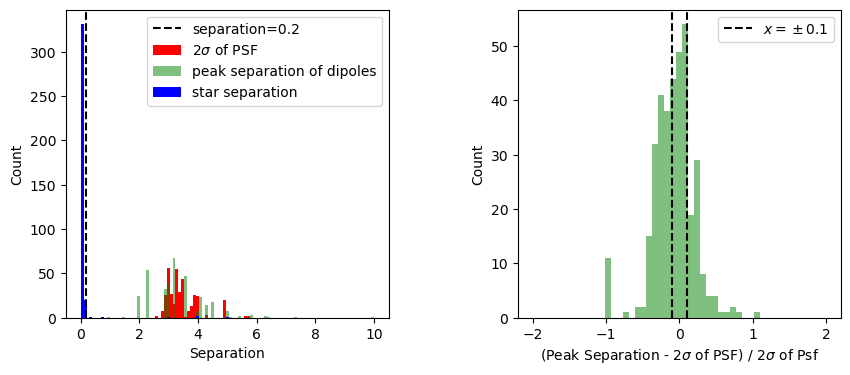

In [41]:
dipole_sep_df = pd.read_csv('./data/table/gal_4639/dipole_separation.csv')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.subplots_adjust(wspace=0.4)
density = False
ax[0].hist(dipole_sep_df['psf_sep'], bins=np.linspace(0,10,100), density=density,
         color='r', label='2$\sigma$ of PSF');
ax[0].hist(dipole_sep_df['peak_sep'], bins=np.linspace(0,10,100), density=density,
         color='g', label='peak separation of dipoles', alpha=0.5)
ax[0].hist(dipole_sep_df['star_sep_diaSrc'], bins=np.linspace(0,10,100), density=density,
         color='blue', label='star separation')
x_threshold = 0.2
ax[0].axvline(x=x_threshold, color='k', linestyle='dashed', label=f'separation={x_threshold}')
ax[0].set_xlabel('Separation')
ax[0].set_ylabel('Count')
ax[0].legend()
sep_res = (dipole_sep_df['peak_sep'] - dipole_sep_df['psf_sep']) / dipole_sep_df['psf_sep']
ax[1].hist(sep_res, bins = np.linspace(-2, 2, 50), density=density, color='g', alpha=0.5);
ax[1].axvline(x=-0.1, color='k', linestyle='dashed', label='$x=\pm 0.1$')
ax[1].axvline(x=0.1, color='k', linestyle='dashed')
ax[1].set_xlabel('(Peak Separation - $2\sigma$ of PSF) / $2\sigma$ of Psf')
ax[1].set_ylabel('Count');
ax[1].legend()
plt.savefig('./plots_and_tables/star_separation.pdf')

In [42]:
sep_res = (dipole_sep_df['peak_sep'] - dipole_sep_df['psf_sep']) / dipole_sep_df['psf_sep']
(sep_res < 0.1).sum() / len(sep_res)

0.778393351800554

In [43]:
(sep_res < 0.1).sum()

281

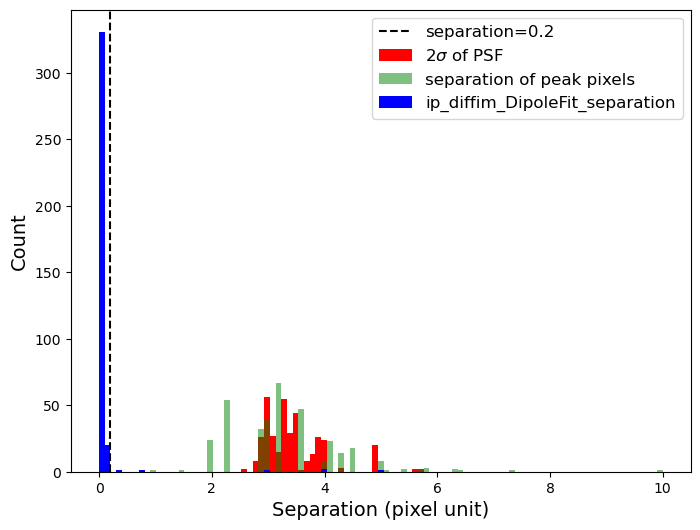

In [51]:
dipole_sep_df = pd.read_csv('./data/table/gal_4639/dipole_separation.csv')

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.subplots_adjust(wspace=0.4)
density = False
ax.hist(dipole_sep_df['psf_sep'], bins=np.linspace(0,10,100), density=density,
         color='r', label='2$\sigma$ of PSF');
ax.hist(dipole_sep_df['peak_sep'], bins=np.linspace(0,10,100), density=density,
         color='g', label='separation of peak pixels', alpha=0.5)
ax.hist(dipole_sep_df['star_sep_diaSrc'], bins=np.linspace(0,10,100), density=density,
         color='blue', label='ip_diffim_DipoleFit_separation')
x_threshold = 0.2
ax.axvline(x=x_threshold, color='k', linestyle='dashed', label=f'separation={x_threshold}')
ax.set_xlabel('Separation (pixel unit)', size=14)
ax.set_ylabel('Count',size=14)
ax.legend(fontsize=12)

plt.savefig('./plots_and_tables/star_separation.pdf')